# Prepare training tensor

Create a tensor with columns [x_norm, y_norm, flux_x_scaled, flux_y_scaled]

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import torch
import matplotlib.pyplot as plt

In [2]:
# Load thickness points
thickness = pd.read_csv("data/bedmap123_ross_onshelf_3M.csv")

In [5]:
ice_vel = xr.load_dataset("/home/kim/data/nsidc/antarctic_ice_vel_phase_map_v01.nc")

x_min = - 600_000
x_max = 400_000
y_min = - 1_400_000
y_max = - 400_000

velocity = ice_vel.sel(
    x = slice(x_min, x_max), 
    y = slice(y_max, y_min))

In [11]:
# Interpolate
vel_at_points = velocity[["VX", "VY"]].interp(
    x = ("points", thickness["x"].values),
    y = ("points", thickness["y"].values),
    method = "linear",
)

# Add to dataset
thickness["VX"] = vel_at_points["VX"].values
thickness["VY"] = vel_at_points["VY"].values

print(thickness.shape)

(3227508, 15)


In [12]:
thickness["VX"] = vel_at_points["VX"].values
thickness["VY"] = vel_at_points["VY"].values
# thickness["speed"] = np.hypot(thickness["VX"], thickness["VY"])

# Multiply velocity components by thickness (t_fa) to get flux components
thickness["VX_flux"] = thickness["VX"] * thickness["t_fa"]
thickness["VY_flux"] = thickness["VY"] * thickness["t_fa"]

# If you also want total flux magnitude
thickness["flux_mag"] = np.hypot(thickness["VX_flux"], thickness["VY_flux"])

# Optionally drop rows with NaNs if you want a clean dataset
# Check for NaNs
print(thickness[["VX_flux", "VY_flux", "flux_mag"]].isna().sum())
# Remove
thickness = thickness.dropna(subset = ["VX_flux", "VY_flux", "flux_mag"])
print(thickness.shape)

VX_flux     0
VY_flux     0
flux_mag    0
dtype: int64
(3227508, 15)


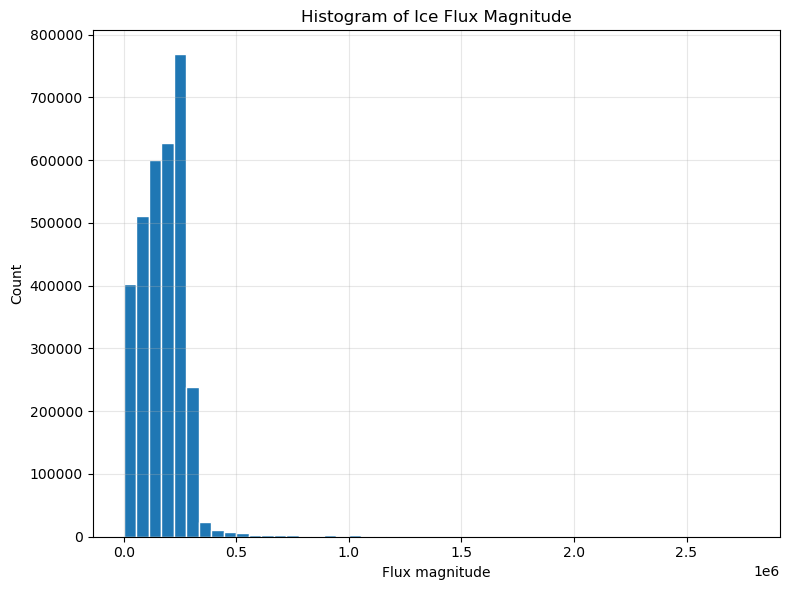

In [13]:
plt.figure(figsize = (8, 6))
plt.hist(thickness["flux_mag"], bins = 50, edgecolor="white")
plt.xlabel("Flux magnitude")
plt.ylabel("Count")
plt.title("Histogram of Ice Flux Magnitude")
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

In [16]:
# Print variance after normalisation
print(np.var(thickness["VX_flux"] / 100_000))
print(np.var(thickness["VY_flux"] / 100_000))

1.473730288176075
1.0880440840194148


In [17]:
# Normalize into [0, 1]
thickness["x_norm"] = (thickness["x"] - x_min) / (x_max - x_min)
thickness["y_norm"] = (thickness["y"] - y_min) / (y_max - y_min)

# Build tensor with x_norm, y_norm, scaled flux
flux_tensor = torch.tensor(
    np.stack([
        thickness["x_norm"].values,
        thickness["y_norm"].values,
        thickness["VX_flux"].values / 100_000,
        thickness["VY_flux"].values / 100_000,
    ], axis = 1),
    dtype = torch.float32
)

print(flux_tensor.shape)
print(flux_tensor[:5])  # preview first rows

torch.Size([3227508, 4])
tensor([[ 0.3674,  0.2412, -0.5594, -2.4007],
        [ 0.4251,  0.2271, -0.5252, -2.4452],
        [ 0.4743,  0.2073, -0.7175, -2.8999],
        [ 0.5392,  0.2003, -0.5343, -2.9448],
        [ 0.6142,  0.2098, -0.5676, -3.2343]])


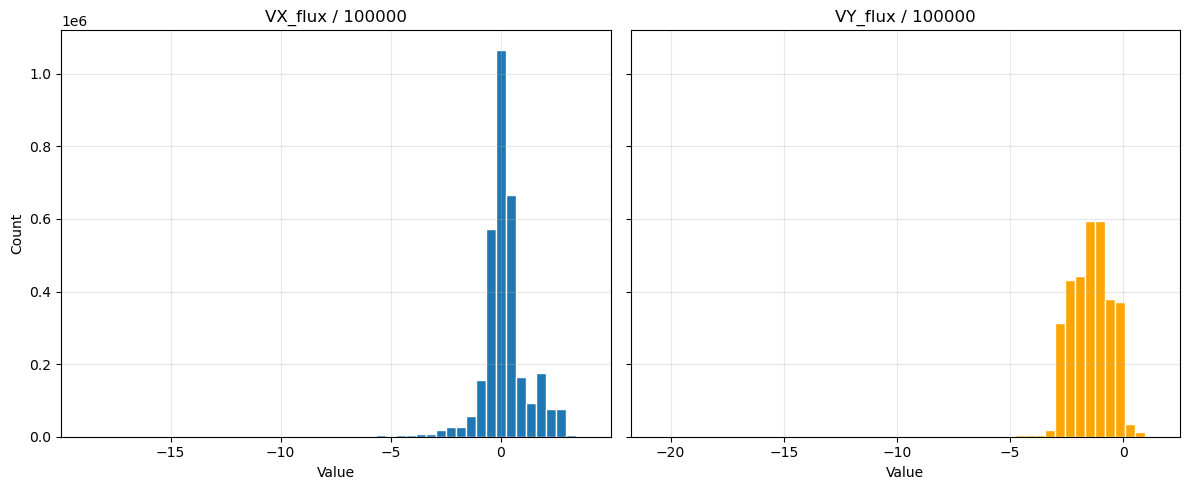

In [18]:
import matplotlib.pyplot as plt

# Extract the last two columns
vx_flux_scaled = flux_tensor[:, 2].numpy()
vy_flux_scaled = flux_tensor[:, 3].numpy()

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize = (12, 5), sharey = True)

axes[0].hist(vx_flux_scaled, bins = 50, edgecolor = "white")
axes[0].set_title("VX_flux / 100000")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Count")
axes[0].grid(alpha = 0.3)

axes[1].hist(vy_flux_scaled, bins = 50, edgecolor = "white", color = "orange")
axes[1].set_title("VY_flux / 100000")
axes[1].set_xlabel("Value")
axes[1].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

In [19]:
torch.save(flux_tensor, "data/flux_train_tensor.pt")